In [1]:
# === Імпорт необхідних бібліотек ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

# Встановлюємо стиль для графіків
sns.set(style='whitegrid')

In [2]:
# Частина 1. Робота з датасетом 'data_2d.csv' 
# --- Крок 1: Завантаження даних ---
data_2d_path = os.path.join('data', 'data_2d.csv')
try:
    data_2d = pd.read_csv(data_2d_path, header=None)
    print("Датасет data_2d.csv завантажено. Розмір:", data_2d.shape)
    print("Перші 5 рядків:")
    print(data_2d.head())
except FileNotFoundError:
    print(f"Помилка: файл {data_2d_path} не знайдено.")

Датасет data_2d.csv завантажено. Розмір: (200, 3)
Перші 5 рядків:
     0         1         2
0  0.0 -0.768716  0.460860
1  0.0  2.687848  2.366961
2  0.0 -0.201379  0.470430
3  0.0  0.608496  1.225400
4  0.0 -0.082282  1.137218


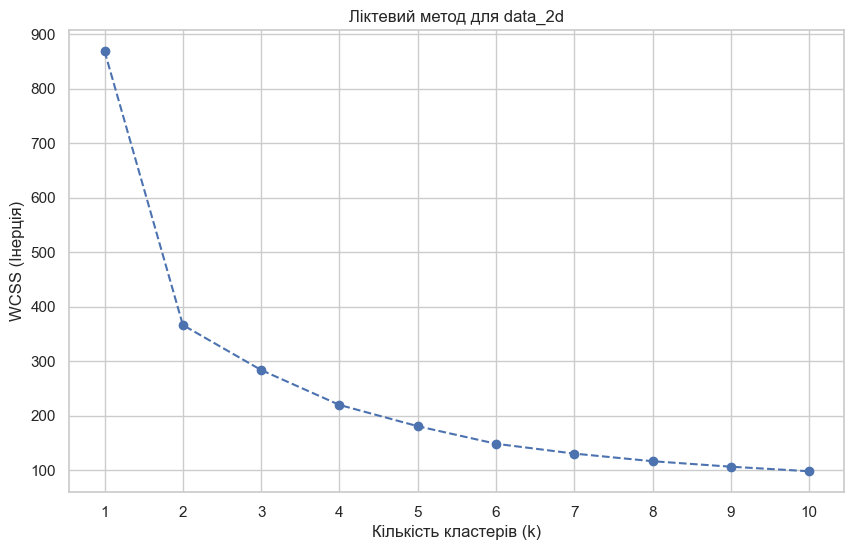

In [4]:
# --- Крок 2: Пошук оптимальної кількості кластерів (Ліктевий метод) ---
# Inertia (інерція) - це сума квадратів відстаней від кожної точки до центру її кластера.
# Чим менше інерція, тим щільніші кластери.
wcss = [] # Within-Cluster Sum Of Squares (Інерція)
cluster_range = range(1, 11) # Тестуємо від 1 до 10 кластерів
for k in cluster_range:
    k_means = KMeans(n_clusters=k, random_state=42, n_init=10)
    k_means.fit(data_2d)
    wcss.append(k_means.inertia_)
# Візуалізуємо ліктевий метод
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, wcss, marker='o', linestyle='--')
plt.title('Ліктевий метод для data_2d')
plt.xlabel('Кількість кластерів (k)')
plt.ylabel('WCSS (Інерція)')
plt.xticks(cluster_range)
plt.grid(True)
plt.show()

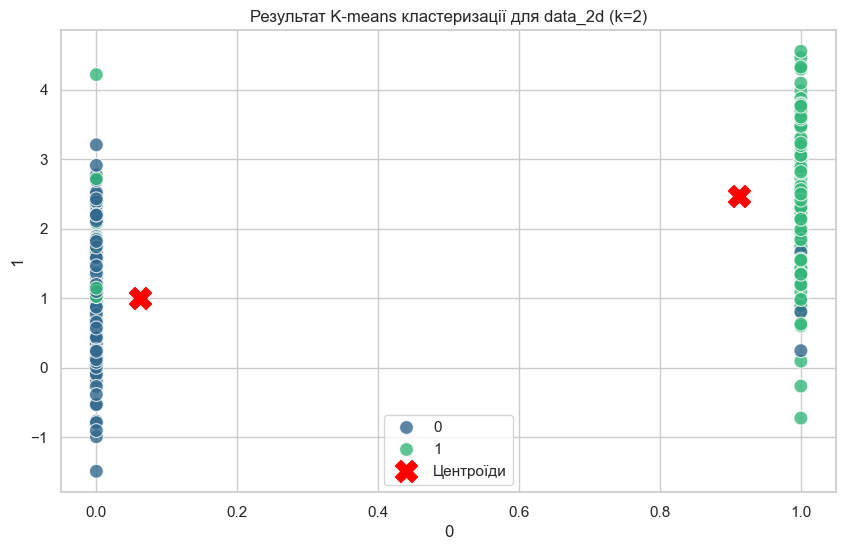

In [6]:
# З графіка видно, що 'лікоть' знаходиться в точці k=2. Це наша оптимальна кількість кластерів.
# --- Крок 3: Кластеризація з оптимальним k та візуалізація ---
optimal_k_2d = 2
k_means_2d = KMeans(n_clusters=2, random_state=42, n_init=10)
# fit_predict навчає модель і одразу повертає мітки кластерів для кожної точки
cluster_labels_2d = k_means_2d.fit_predict(data_2d)

# Додаємо мітки кластерів до нашого датафрейму
data_2d['cluster'] = cluster_labels_2d
# Візуалізуємо результат
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=data_2d,
    x=data_2d.columns[0], # Перший стовпець
    y=data_2d.columns[1], # Другий стовпець
    hue='cluster', # Колір залежить від кластера
    palette='viridis', # Кольорова палітра
    s=100, # Розмір точок
    alpha= 0.8
)
# Додамо центри кластерів на графік
centers = k_means_2d.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='X', label='Центроїди')
plt.title(f'Результат K-means кластеризації для data_2d (k={optimal_k_2d})')
plt.legend()
plt.show()

In [7]:
# Кількісна оцінка роботи моделі за допомогою "правильних відповідей" (зовнішні метрики)
from sklearn import metrics
# Справжні мітки
true_labels = data_2d[data_2d.columns[0]]
# Мітки, присвоєні моделлю KMeans
predicted_labels = k_means_2d.labels_
# 1. Adjusted Rand Index (ARI) — Скоригований індекс Ренда
# Інтуїція: Вимірює схожість між двома способами групування даних (справжнім і тим, що знайшла модель).
# Інтерпретація:
# 1.0: Ідеальний збіг.
# 0.0: Результат не кращий за випадковий.
# Негативне значення: Результат гірший за випадковий.
ari_score = metrics.adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index: {ari_score:.3f}")

Adjusted Rand Index: 0.721


In [8]:
# 2. Homogeneity, Completeness, and V-measure
# Це три пов'язані метрики, що базуються на теорії інформації.
# Homogeneity (Однорідність):
# Інтуїція: "Чи кожен кластер складається з точок, що належать тільки до одного справжнього класу?". 
# Максимальна, якщо модель не змішує різні цифри в одному кластері.
# Completeness (Повнота):
# Інтуїція: "Чи всі точки, що належать до одного справжнього класу, потрапили в один і той самий кластер?". 
# Максимальна, якщо модель не "розкидає" одну й ту ж цифру по різним кластерам.
# V-measure:
# Інтуїція: Гармонійне середнє між однорідністю та повнотою. Це єдиний збалансований показник.
# Інтерпретація: Всі три метрики знаходяться в діапазоні від 0 до 1, де 1 — ідеальний результат.
homogeneity = metrics.homogeneity_score(true_labels, predicted_labels)
completeness = metrics.completeness_score(true_labels, predicted_labels)
v_measure = metrics.v_measure_score(true_labels, predicted_labels)
print(f"Homogeneity: {homogeneity:.3f}")
print(f"Completeness: {completeness:.3f}")
print(f"V-measure: {v_measure:.3f}")

Homogeneity: 0.617
Completeness: 0.618
V-measure: 0.618


In [9]:
# Висновок: Модель K-means, застосована до двовимірної проекції даних, 
# продемонструвала хорошу здатність до групування даних, досягнувши скоригованого індексу Ренда 0.721. 
# Це вказує на те, що знайдені кластери значною мірою відповідають справжнім класам цифр. 
# Помірні значення однорідності та повноти (близько 0.62) свідчать про те, 
# що модель іноді змішувала схожі цифри або розділяла варіації однієї цифри на різні кластери, 
# що є очікуваним результатом з огляду на втрату інформації при зменшенні розмірності.

In [10]:
# Частина 2. Робота з датасетом 'mnist.csv'
# --- Крок 1: Завантаження та підготовка даних MNIST ---
mnist_path = os.path.join('data', 'mnist.csv')
# mnist_path = 'mnist.csv'
try:
    mnist_data = pd.read_csv(mnist_path, header=None)
    print('Датасет mnist.csv завантажено. Розмір:', mnist_data.shape)
    print('Перші 5 рядків:')
    print(mnist_data.head())
except FileNotFoundError: 
    print(f"Помилка: файл {mnist_path} не знайдено.")

Датасет mnist.csv завантажено. Розмір: (500, 785)
Перші 5 рядків:
   0    1    2    3    4    5    6    7    8    9    ...  775  776  777  778  \
0    7    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
1    2    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
2    1    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
3    0    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   
4    4    0    0    0    0    0    0    0    0    0  ...    0    0    0    0   

   779  780  781  782  783  784  
0    0    0    0    0    0    0  
1    0    0    0    0    0    0  
2    0    0    0    0    0    0  
3    0    0    0    0    0    0  
4    0    0    0    0    0    0  

[5 rows x 785 columns]


In [11]:
# Перевіримо основні статистичні показники, для кожного стовпця
mnist_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,500.000000,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,...,500.000000,500.000000,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,4.378000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.506000,0.256000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.873958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.314504,5.724334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
# Не використовуємо стовпець-мітку, але зберігаємо для фінального аналізу
X_mnist = mnist_data.iloc[:, 1:]
y_mnist_true = mnist_data.iloc[:, 0]

In [20]:
# Отримати всі унікальні значення
unique_classes = y_mnist_true.unique()
print(f"Відсортовані унікальні класи: {np.sort(unique_classes)}")

Відсортовані унікальні класи: [0 1 2 3 4 5 6 7 8 9]


In [13]:
# Нормалізація даних
scaler = StandardScaler()
X_mnist_scaled = scaler.fit_transform(X_mnist)

In [15]:
# --- Крок 2: Зменшення Розмірності за допомогою PCA ---
# Створюємо об'єкт PCA, який залишить 2 головні компоненти
pca = PCA(n_components=2) 
# Навчаємо PCA на наших нормалізованих даних і трансформуємо їх
X_mnist_2d = pca.fit_transform(X_mnist_scaled)
print(X_mnist_2d.shape)

(500, 2)


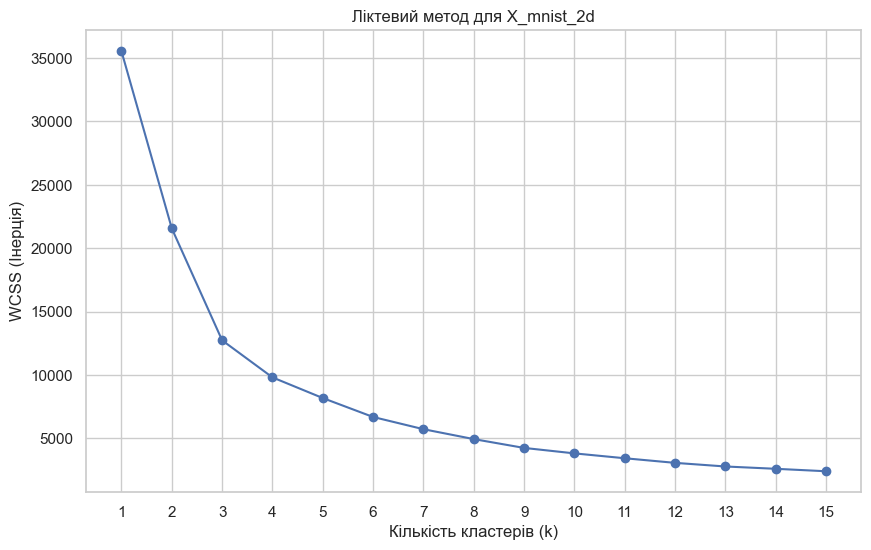

In [18]:
# Пошук Оптимального k за допомогою Ліктьового Методу
inertia_list = [] 
possible_k = range(1, 16)

for k in possible_k:
    k_means_test = KMeans(n_clusters=k, random_state=42, n_init=10)
    k_means_test.fit(X_mnist_2d)
    inertia_list.append(k_means_test.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(possible_k, inertia_list, 'bo-')
plt.title('Ліктевий метод для X_mnist_2d')
plt.xlabel('Кількість кластерів (k)')
plt.ylabel('WCSS (Інерція)')
plt.xticks(possible_k)
plt.grid(True)
plt.show()

In [21]:
# Згідно з ліктьовим методом, застосованим до 2D-даних, оптимальною кількістю кластерів є 3 (або 4). 
# Це свідчить про те, що після зменшення розмірності дані утворюють кілька великих, добре розділених мета-груп.
# Однак, оскільки з предметної області відомо, що датасет містить 10 різних класів (цифри від 0 до 9), 
# для подальшого аналізу та інтерпретації ми будемо використовувати k=10. Це дозволить нам перевірити, 
# наскільки добре алгоритм може розділити ці більш тонкі структури, навіть якщо вони не є очевидними у 2D-проекції.
 

In [22]:
# --- Крок 3: Кластеризація за допомогою K-Means ---
final_kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
# Навчаємо модель на 2D-даних і отримуємо мітки кластерів для кожної точки
pred_labels = final_kmeans.fit_predict(X_mnist_2d)

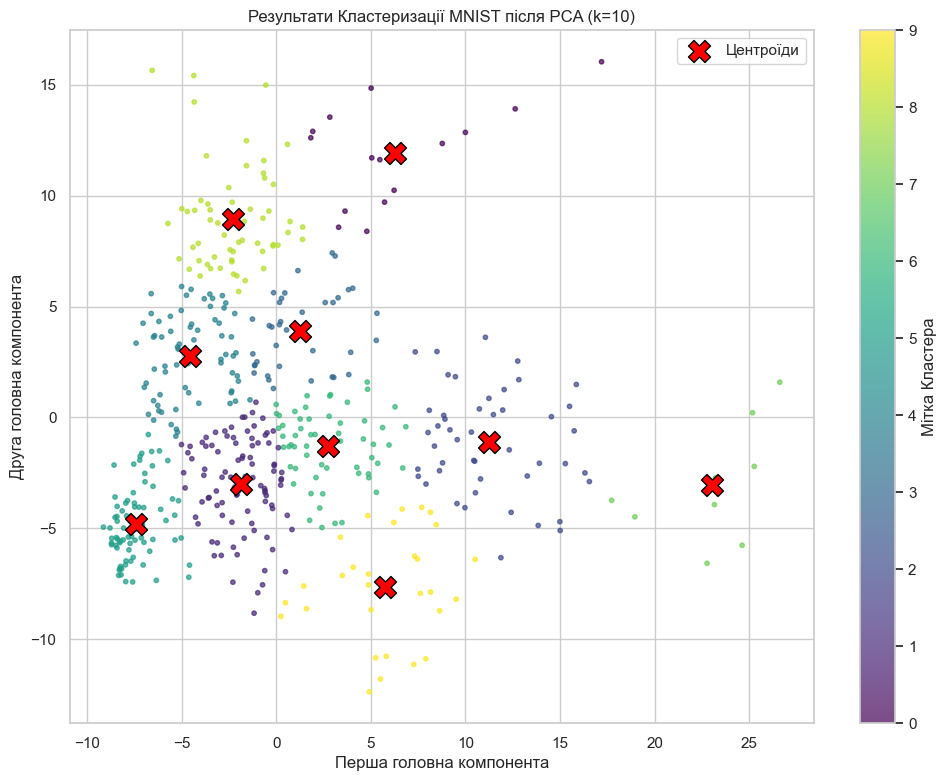

In [25]:
# --- Крок 4: Візуалізація "Карти Кластерів" ---
plt.figure(figsize=(12, 9))
scatter = plt.scatter(X_mnist_2d[:, 0], X_mnist_2d[:, 1], c=pred_labels, cmap='viridis', s=10, alpha=0.7)

# --- Додатково: візуалізуємо центри кластерів (центроїди) ---
# Отримуємо координати центрів з навченої моделі kmeans
centers = final_kmeans.cluster_centers_

# Малюємо центри поверх основного графіка як великі червоні хрестики
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=250, marker='X', label='Центроїди', edgecolors='black')
plt.title("Результати Кластеризації MNIST після PCA (k=10)")
plt.xlabel("Перша головна компонента")
plt.ylabel("Друга головна компонента")

# Додаємо легенду (щоб відобразити мітку "Центроїди")
plt.legend()

# Додаємо кольорову шкалу (colorbar), яка показує, який колір якому кластеру відповідає
plt.colorbar(scatter, ticks=range(10), label='Мітка Кластера')
plt.show()

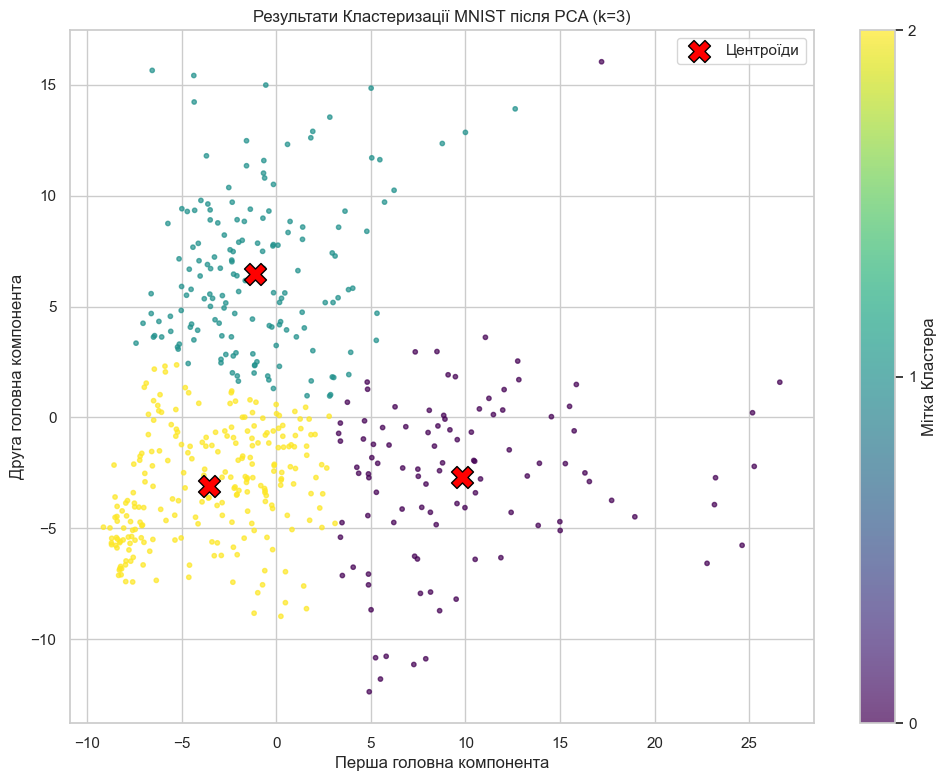

In [28]:
# Поглянемо також на результат кластеризації, використовуючи n_clusters=3, після застосування ліктевого методу
kmeans_2d = KMeans(n_clusters=3, random_state=42, n_init=10)
pred_labels_2d = kmeans_2d.fit_predict(X_mnist_2d)
# Візуалізація
plt.figure(figsize=(12, 9))
scatter_2d = plt.scatter(X_mnist_2d[:, 0], X_mnist_2d[:, 1], c=pred_labels_2d, cmap='viridis', s=10, alpha=0.7)
centers_2d = kmeans_2d.cluster_centers_
plt.scatter(centers_2d[:, 0], centers_2d[:, 1], c='red', s=250, marker='X', label='Центроїди', edgecolor='black')
plt.title("Результати Кластеризації MNIST після PCA (k=3)")
plt.xlabel("Перша головна компонента")
plt.ylabel("Друга головна компонента")
plt.legend()
plt.colorbar(scatter_2d, ticks=range(3), label='Мітка Кластера')
plt.show()


--- Кластер #0 ---
Знайдено 104 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0    35
2    24
3    11
4     2
5     9
6    17
8     6
Name: count, dtype: int64


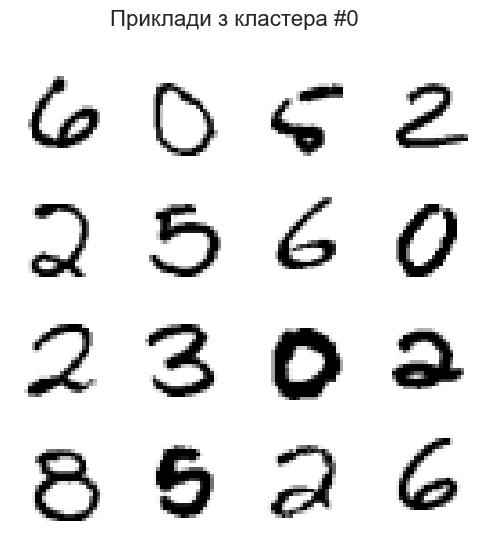


--- Кластер #1 ---
Знайдено 157 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0     1
2     4
3     4
4    40
5    10
6     3
7    33
8    16
9    46
Name: count, dtype: int64


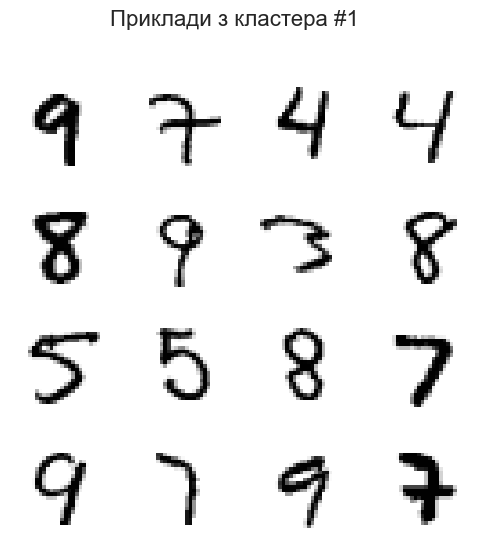


--- Кластер #2 ---
Знайдено 239 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0     6
1    67
2    27
3    30
4    13
5    31
6    23
7    16
8    18
9     8
Name: count, dtype: int64


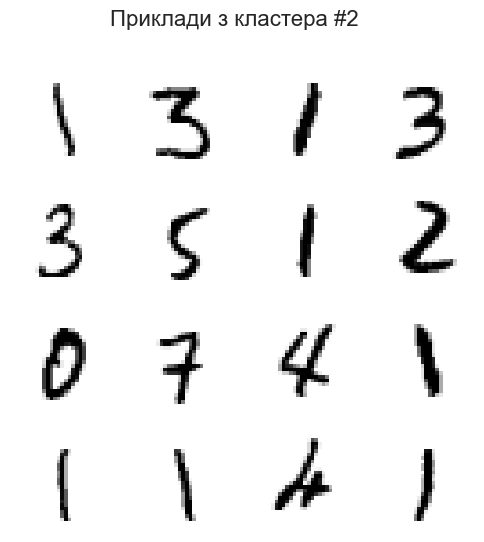

In [31]:
# --- Аналізуємо кожен з трьох кластерів ---
for cluster_id in range(3):
    # Знаходимо індекси всіх зображень в поточному кластері
    indices = np.where(pred_labels_2d == cluster_id)[0]
    
    # Виводимо, які справжні цифри домінують в цьому кластері
    true_labels_in_cluster = y_mnist_true.iloc[indices]
    print(f"\n--- Кластер #{cluster_id} ---")
    print(f"Знайдено {len(indices)} зображень.")
    print("Розподіл справжніх цифр у цьому кластері:")
    print(true_labels_in_cluster.value_counts().sort_index())

    # --- Візуалізація 16 випадкових зображень з кластера ---
    images_to_show = X_mnist.iloc[np.random.choice(indices, size=16, replace=False)]
    
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    fig.suptitle(f"Приклади з кластера #{cluster_id}", fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        image_matrix = images_to_show.iloc[i].to_numpy().reshape(28, 28)
        ax.imshow(image_matrix, cmap='gray_r')
        ax.axis('off')
        
    plt.show()


--- Кластер #0 ---
Знайдено 15 зображень.
Розподіл справжніх цифр у цьому кластері:
0
4    12
9     3
Name: count, dtype: int64


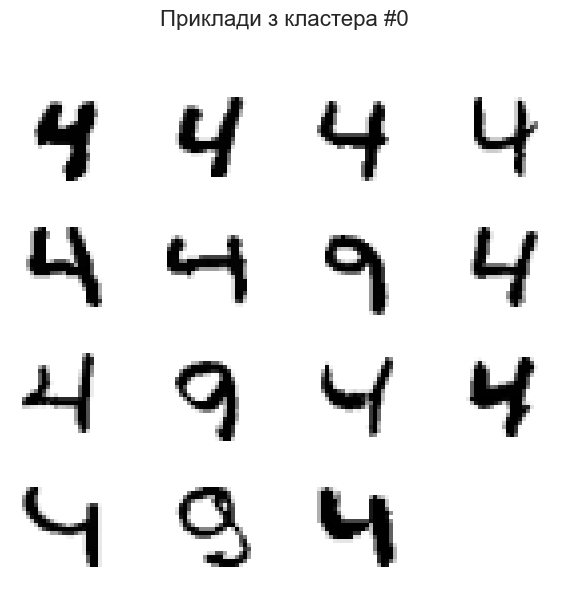


--- Кластер #1 ---
Знайдено 98 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0     2
1     1
2    18
3    19
4     3
5    22
6    14
7     3
8    13
9     3
Name: count, dtype: int64


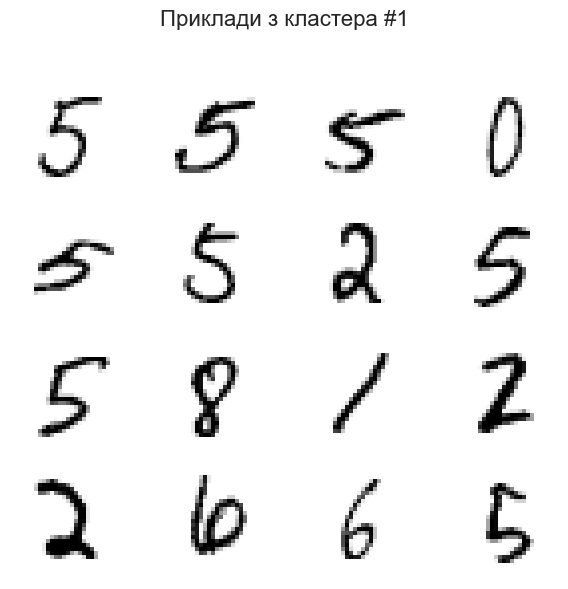


--- Кластер #2 ---
Знайдено 47 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0    19
2     4
3     6
4     1
5     4
6    10
8     3
Name: count, dtype: int64


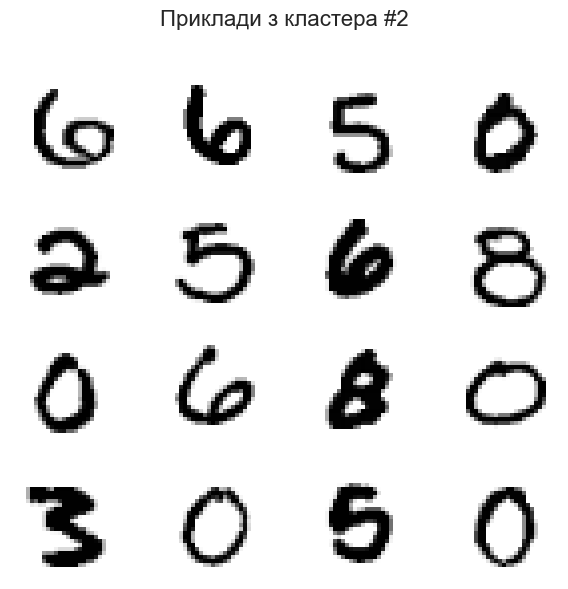


--- Кластер #3 ---
Знайдено 39 зображень.
Розподіл справжніх цифр у цьому кластері:
0
2     2
3     2
4     8
5     7
6     2
7     3
8    11
9     4
Name: count, dtype: int64


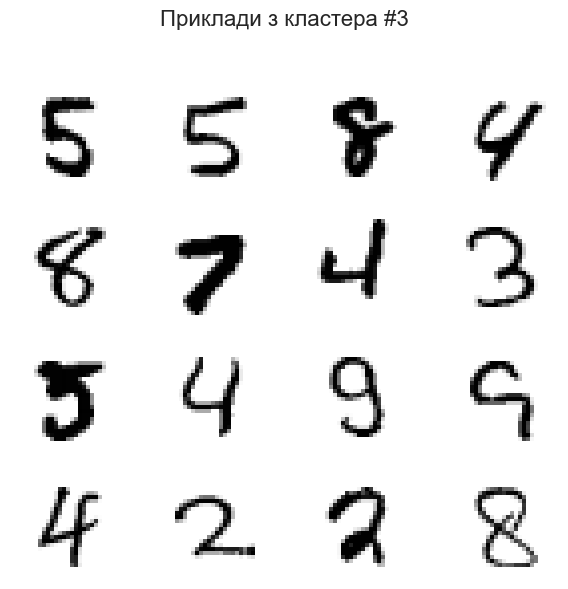


--- Кластер #4 ---
Знайдено 68 зображень.
Розподіл справжніх цифр у цьому кластері:
0
1     1
2     2
3     2
4    18
5     4
6     1
7    19
8     5
9    16
Name: count, dtype: int64


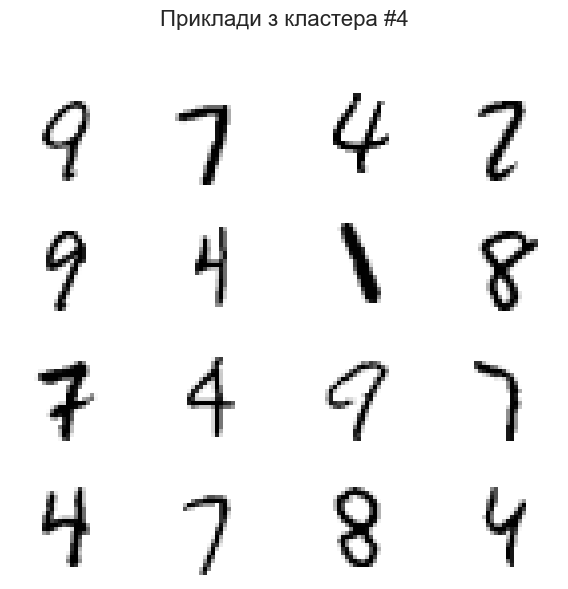


--- Кластер #5 ---
Знайдено 78 зображень.
Розподіл справжніх цифр у цьому кластері:
0
1    65
3     2
4     1
5     2
6     1
7     4
8     1
9     2
Name: count, dtype: int64


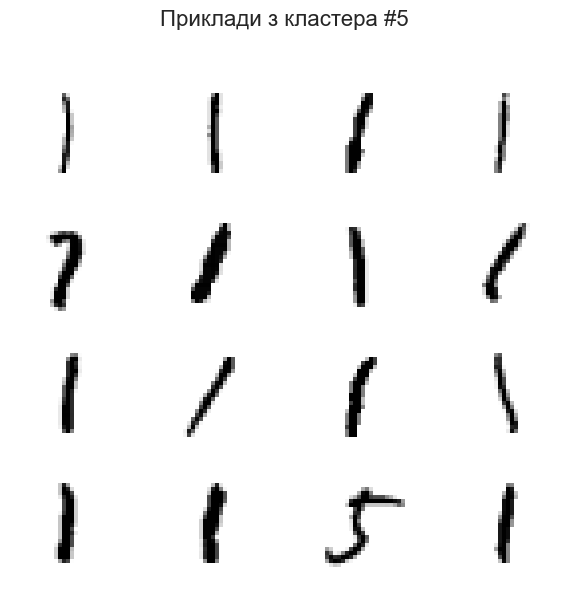


--- Кластер #6 ---
Знайдено 58 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0    11
2     7
3     9
4     1
5    10
6    14
7     1
8     5
Name: count, dtype: int64


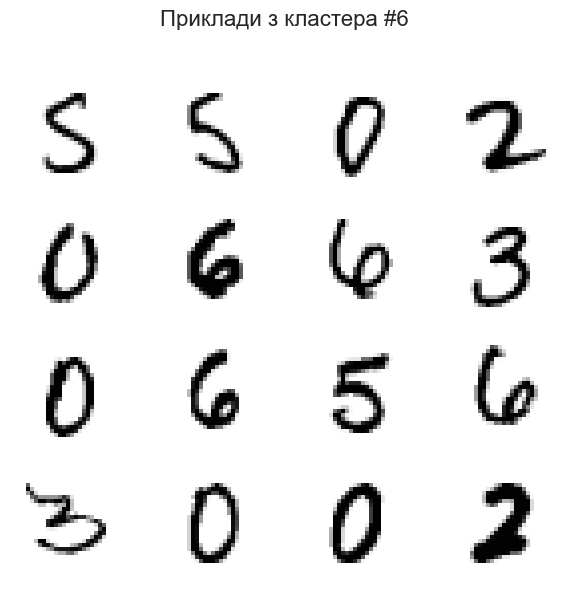


--- Кластер #7 ---
Знайдено 9 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0    9
Name: count, dtype: int64


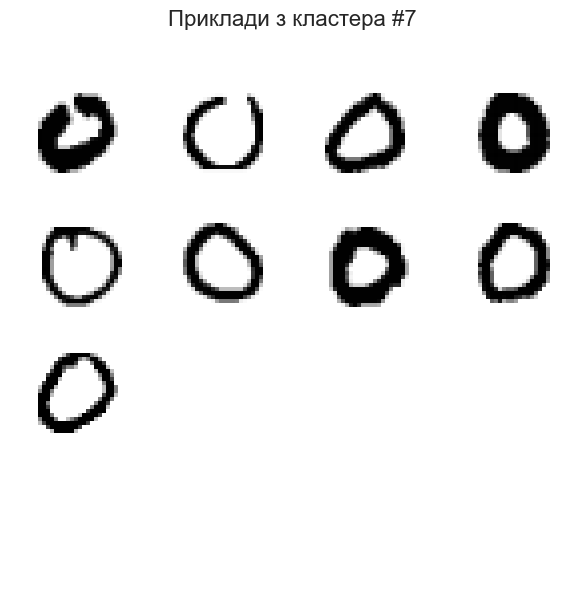


--- Кластер #8 ---
Знайдено 59 зображень.
Розподіл справжніх цифр у цьому кластері:
0
2     1
3     1
4    11
7    19
8     1
9    26
Name: count, dtype: int64


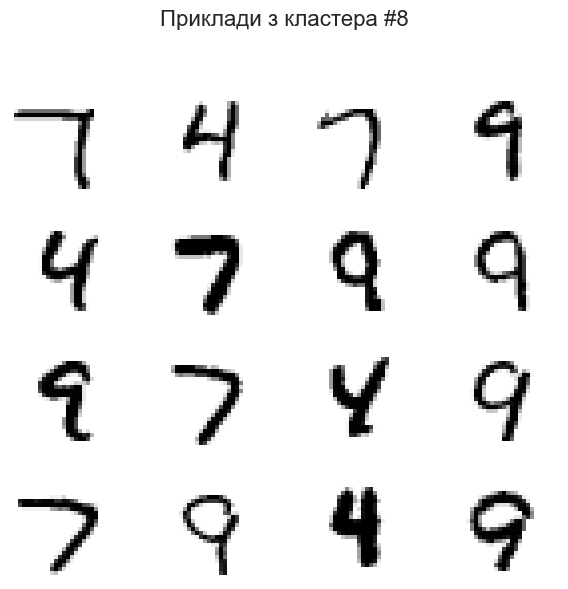


--- Кластер #9 ---
Знайдено 29 зображень.
Розподіл справжніх цифр у цьому кластері:
0
0     1
2    21
3     4
5     1
6     1
8     1
Name: count, dtype: int64


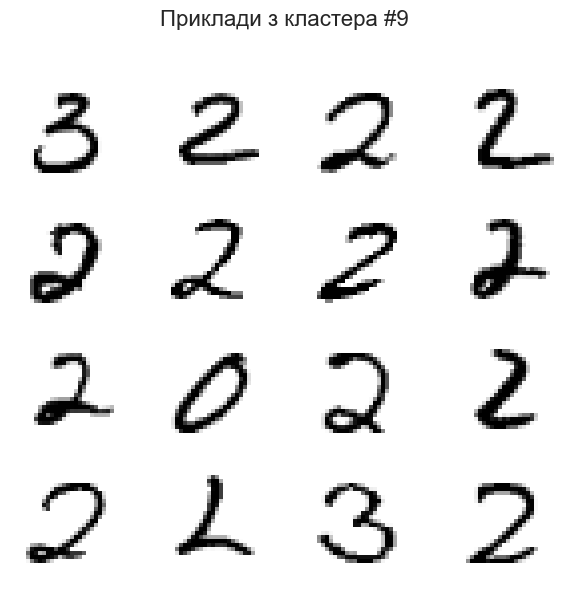

In [33]:
# --- Аналізуємо кожен з десятьох кластерів ---
for cluster_id in range(10):
    # Знаходимо індекси всіх зображень в поточному кластері
    indices = np.where(pred_labels == cluster_id)[0]
    
    # Виводимо, які справжні цифри домінують в цьому кластері
    true_labels_in_cluster = y_mnist_true.iloc[indices]
    print(f"\n--- Кластер #{cluster_id} ---")
    print(f"Знайдено {len(indices)} зображень.")
    print("Розподіл справжніх цифр у цьому кластері:")
    print(true_labels_in_cluster.value_counts().sort_index())
    
    # Визначаємо, скільки зображень ми можемо показати (максимум 16)
    num_to_show = min(len(indices), 16)
    
    # Перевіряємо, чи є в кластері хоча б одне зображення
    if num_to_show > 0:
        # Вибираємо випадкові індекси, кількість яких не перевищує розмір кластера
        random_indices_to_show = np.random.choice(indices, size=num_to_show, replace=False)
        
        # Отримуємо самі дані зображень за цими індексами
        images_to_show = X_mnist.iloc[random_indices_to_show]
        
        fig, axes = plt.subplots(4, 4, figsize=(6, 6))
        fig.suptitle(f"Приклади з кластера #{cluster_id}", fontsize=16)
        
        for i, ax in enumerate(axes.flat):
            # Малюємо зображення, лише якщо воно існує
            if i < len(images_to_show):
                image_matrix = images_to_show.iloc[i].to_numpy().reshape(28, 28)
                ax.imshow(image_matrix, cmap='gray_r')
            
            # Вимикаємо осі для всіх клітинок сітки, навіть для порожніх
            ax.axis('off')
            
        plt.tight_layout(rect=[0, 0, 1, 0.96]) # Додано для кращого розташування заголовка
        plt.show()
    else:
        print("В цьому кластері немає зображень для показу.")

In [34]:
# Аналіз з k=3, який був запропонований ліктьовим методом, показав, що у 2D-проекції дані природно утворюють три великі мета-групи. 
# Аналіз вмісту цих груп показав, що PCA, ймовірно, згрупував цифри за їхніми візуальними характеристиками: "округлі" цифри (0, 6, 8, 9), 
# "вертикальні" (1, 7) та "змішані".
# Це демонструє, які саме ознаки алгоритм PCA виділив як найважливіші (головні компоненти), 
# втративши при цьому більш тонкі відмінності між окремими цифрами.

In [35]:
# Аналіз з k=10, який базується на знанні про 10 класів у датасеті, продемонстрував спробу алгоритму розділити ці мета-групи.
# Деякі цифри, такі як 0 та 1, утворили досить "чисті" кластери,
# що свідчить про їхнє унікальне представлення у 2D-просторі. 
# Водночас інші цифри, наприклад, 4 та 9 або 3 та 5, часто опинялися у змішаних кластерах.